In [1]:
import numpy as np
from scipy.spatial import distance
import pandas as pd
import os
from glob import glob
pd.set_option("display.precision", 2)

In [2]:
INPUT="../data"
FileName=glob(os.path.join(INPUT,"*regions_props*"))

## Find File Prefix
FileList=glob(os.path.join(INPUT,"*.avi"))
head, tail = os.path.split(FileList[0])
FilePrefix=tail.split(".avi")[0]
print(FilePrefix)

supplementaryMovie5_ancestor_ALI


## Linking distance
Linking_distance is a key parameter here, 
how far the objects can move in consecutive frames 

In [5]:
Linking_distance=3
MinLengthTraj=5

In [22]:
Region_props=pd.read_csv(FileName[0])
Region_props.rename(columns={"Unnamed: 0": "point_id"},inplace=True)
Region_props["traj_id"]=None
Region_props["dist"]=None

In [23]:
FileName

['../data/supplementaryMovie5_ancestor_ALI_regions_props_start_f=62end_f=89.csv']

## Create list of candidates for linking

Link two consecutive frame. 

Result_data_frame:
    * prev_id
    * next_id
    * distance

In [24]:

Result_data_frame=pd.DataFrame()

max_frame=np.int(Region_props.frame.max())

for frame in range(max_frame):
    prev=Region_props[Region_props.frame==frame]
    next=Region_props[Region_props.frame==(frame+1)]
    
    prev_coords =list(zip(prev.c.values,prev.r.values))
    next_coords =list(zip(next.c.values,next.r.values))
    Distance_matrix=distance.cdist(prev_coords, next_coords, 'euclidean')

    indices = np.argmin(Distance_matrix,axis=1)
    values=np.min(Distance_matrix,axis=1)
    result_data_frame=pd.DataFrame({"prev_ind":prev['point_id'].values,
                                    "next_ind":next['point_id'].iloc[indices],
                                    "dist":values})
    Result_data_frame=pd.concat([Result_data_frame,result_data_frame])

# column for further linking
Result_data_frame['flag']=0


# filter distante connection
Result_data_frame=Result_data_frame[Result_data_frame.dist<Linking_distance]
print(Result_data_frame.shape)

(103100, 4)


In [25]:
Result_data_frame.to_csv(os.path.join(INPUT,FilePrefix)+"_List_for_linking.csv")
Result_data_frame= Result_data_frame.astype({"prev_ind": int, "next_ind": int})

## Assemble trajectories

In [26]:
id=0


while Result_data_frame.size>0:
    exit_value=0
    traj=[]
    dist=[0]
    t2=Result_data_frame.prev_ind.iloc[0]
    traj.append(t2)
    
    while (exit_value==0):
        selected_row=Result_data_frame[Result_data_frame.prev_ind==t2]
        
        if selected_row.size==0:
            exit_value=1
            Region_props.loc[Region_props["point_id"].isin(traj),"traj_id"]=id
            Region_props.loc[Region_props["point_id"].isin(traj),"dist"]=dist
            id=id+1
            #print(traj)
           
        else:
            # marked point as used
            Result_data_frame.loc[(Result_data_frame.prev_ind==t2),"flag"]=-1
            
            #update t2 and index
            t2=selected_row.next_ind.values[0]
            current_dist=selected_row.dist.values[0]
            
            # filter out point that has been already used
            Result_data_frame=Result_data_frame[Result_data_frame.flag>=0]
            
            traj.append(t2)
            dist.append(current_dist)

In [27]:
Traj_data=Region_props
Traj_data.reset_index(inplace=True)
Traj_data=Traj_data[['traj_id','point_id','frame','r','c','dist','minr','minc',
                     'maxr','maxc','area','major_axis','minor_axis','perimeter','eccentricity']]
print("Traj_data",Traj_data.shape)
Traj_data.to_csv(os.path.join(INPUT,FilePrefix)+"_Traj_data.csv")

Traj_data (124782, 15)


## Filter Trajectories longer than 5 frames

In [7]:
Region_props=pd.read_csv("../data/supplementaryMovie5_ancestor_ALI_Traj_data.csv")

(96829, 16)


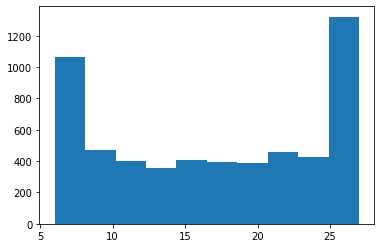

In [8]:
import matplotlib.pyplot as plt
Traj_selected=Region_props.groupby("traj_id").filter(lambda x: len(x["frame"])>MinLengthTraj)
plt.hist(Traj_selected.groupby("traj_id")["frame"].agg(len));
print(Traj_selected.shape)

## Filter out non-colonies objects greater than 100px and less than 9px

In [9]:
Traj_selected=Traj_selected.groupby("traj_id").filter(lambda traj:((traj["area"].max()<100)&(traj["area"].min()>3)))
print(Traj_selected.shape)

(83654, 16)


In [10]:
Traj_selected.dist.max()

2.9995068628224035

In [11]:
Traj_selected.to_csv(os.path.join(INPUT,FilePrefix)+"_Traj_data_cleaned_3px_min_area.csv")